In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm
from torch.utils.tensorboard import SummaryWriter


In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = timm.create_model("tf_efficientnet_b4_ns",pretrained=True) 
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features=1792, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=7, bias=True))
        
        self.FILE = "model.pth"
        self.in_size = (3,224,224)
    def save_model(self):
        torch.save(model.state_dict(), FILE)   
    def load_model(self):
        self.model.load_state_dict(torch.load(FILE))
    def train_mode(self):
        self.model.train()
        for param in self.model.parameters():
            param.requires_grad = True
    def eval_mode(self):
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
    def forward(self,x):
        return self.model(x)
    def load_dict(self,dic):
        self.model.load_state_dict(dic,strict=False)
        

In [3]:
x = torch.load("new_data.pth")

In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

transforms_c= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

data_dir = 'data/train'
image_datasets =datasets.ImageFolder(os.path.join(data_dir),transform= transforms_c)
class_names = image_datasets.classes
train_size = int(0.85 * len(image_datasets))
test_size = len(image_datasets) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, test_size], generator=torch.Generator().manual_seed(42))
image_datasets = {  'train':train_dataset,
                    'val':test_dataset
                 }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=12,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) 


['Andezit', 'Bazalt', 'Diyorit', 'Granit', 'Riyolit', 'Siyenit', 'Trakit']


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,checkpoint = 2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if(phase == 'train') and ( (epoch % checkpoint) == 0):
                torch.save(model.state_dict(),"model"+str(epoch)+"dict.pth")
                print("model is saved")
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
x = x.to(device)
x.train_mode()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(x.parameters(), lr=0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
x = train_model(x, criterion, optimizer, step_lr_scheduler, num_epochs=20,checkpoint=5)


Epoch 0/19
----------
train Loss: 0.9046 Acc: 0.6593
model is saved
val Loss: 0.6887 Acc: 0.7991
Epoch 1/19
----------
train Loss: 0.8708 Acc: 0.6874
val Loss: 0.6166 Acc: 0.8291
Epoch 2/19
----------
train Loss: 0.8599 Acc: 0.6904
val Loss: 0.7600 Acc: 0.7735
Epoch 3/19
----------
train Loss: 0.8674 Acc: 0.6775
val Loss: 0.6594 Acc: 0.8291
Epoch 4/19
----------
train Loss: 0.8826 Acc: 0.6798
val Loss: 0.6386 Acc: 0.8120
Epoch 5/19
----------
train Loss: 0.8133 Acc: 0.7078
model is saved
val Loss: 0.5955 Acc: 0.8291
Epoch 6/19
----------
train Loss: 0.8417 Acc: 0.7002
val Loss: 0.6960 Acc: 0.7991
Epoch 7/19
----------
train Loss: 0.9038 Acc: 0.6684
val Loss: 0.6742 Acc: 0.8162
Epoch 8/19
----------
train Loss: 0.8881 Acc: 0.6737
val Loss: 0.6518 Acc: 0.8162
Epoch 9/19
----------
train Loss: 0.8246 Acc: 0.6987
val Loss: 0.6032 Acc: 0.8077
Epoch 10/19
----------
train Loss: 0.8320 Acc: 0.6821
model is saved
val Loss: 0.8619 Acc: 0.7735
Epoch 11/19
----------
train Loss: 0.8284 Acc: 0.694

KeyboardInterrupt: 

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


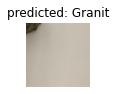

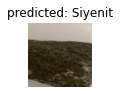

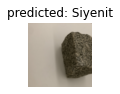

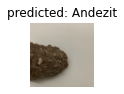

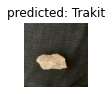

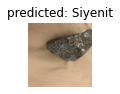

In [9]:
x = x.to(device)
visualize_model(x,6)

In [16]:
def conf_matrix(x):
    nb_classes = 7
    x.eval()
    device = "cuda"
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    x = x.to(device)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = x(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    print((confusion_matrix.diag())/confusion_matrix.sum(1))  
    print(sum(confusion_matrix.diag())/sum(confusion_matrix.sum(1)))        

In [17]:
conf_matrix(y)

tensor([[31.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 1., 42.,  2.,  0.,  0.,  3.,  0.],
        [ 1.,  0., 13.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0., 45.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0., 29.,  0.,  0.],
        [ 0.,  1.,  2.,  0.,  0., 39.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1., 19.]])
tensor([0.9688, 0.8750, 0.8125, 0.9783, 1.0000, 0.9070, 0.9500])
tensor(0.9316)


In [8]:
x.classifier = nn.Sequential(
            nn.Linear(in_features=1792, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=7, bias=True))
        


In [9]:
x = x.to(device)
x.train_mode()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(x.parameters(), lr=0.001,momentum= 0.9)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
x = train_model(x, criterion, optimizer, step_lr_scheduler, num_epochs=15,checkpoint=5)

optimizer = optim.SGD(x.parameters(), lr=0.001,momentum = 0.4)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
x = train_model(x, criterion, optimizer, step_lr_scheduler, num_epochs=15,checkpoint=5)

optimizer = optim.SGD(x.parameters(), lr=0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
x = train_model(x, criterion, optimizer, step_lr_scheduler, num_epochs=15,checkpoint=5)


Epoch 0/14
----------
train Loss: 0.5635 Acc: 0.7994
model is saved
val Loss: 0.3996 Acc: 0.8761
Epoch 1/14
----------
train Loss: 0.4471 Acc: 0.8562
val Loss: 0.3103 Acc: 0.9060
Epoch 2/14
----------
train Loss: 0.4045 Acc: 0.8600
val Loss: 0.3024 Acc: 0.8889
Epoch 3/14
----------
train Loss: 0.3280 Acc: 0.8895
val Loss: 0.2599 Acc: 0.9103
Epoch 4/14
----------
train Loss: 0.2942 Acc: 0.8970
val Loss: 0.2013 Acc: 0.9274
Epoch 5/14
----------
train Loss: 0.2560 Acc: 0.9092
model is saved
val Loss: 0.2863 Acc: 0.9060
Epoch 6/14
----------
train Loss: 0.2760 Acc: 0.9008
val Loss: 0.2563 Acc: 0.9060
Epoch 7/14
----------
train Loss: 0.2872 Acc: 0.8986
val Loss: 0.2438 Acc: 0.9188
Epoch 8/14
----------
train Loss: 0.2864 Acc: 0.9023
val Loss: 0.2528 Acc: 0.9231
Epoch 9/14
----------
train Loss: 0.2496 Acc: 0.9122
val Loss: 0.2040 Acc: 0.9359
Epoch 10/14
----------
train Loss: 0.2809 Acc: 0.8955
model is saved
val Loss: 0.2064 Acc: 0.9274
Epoch 11/14
----------
train Loss: 0.2680 Acc: 0.909

In [10]:
torch.save(x,"0.95 ac.pth")

In [15]:
y = torch.load("0.95 ac.pth")